In [34]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
from tbcontrol.symbolic import routh

In [35]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [47]:
s  = ctl.TransferFunction.s

In [48]:
G  = 0.0206708134012297*(0.155605773*s**2 - 0.400634718*s + 1.0)/(0.15560577*s**2 - 0.78893795*s + 1.0)
#G = 12/((s-10)*(s+5))
#G = (s+20)/(s*(s+2)*(s+3))

G

TransferFunction(array([ 0.0032165 , -0.00828145,  0.02067081]), array([ 0.15560577, -0.78893795,  1.        ]))

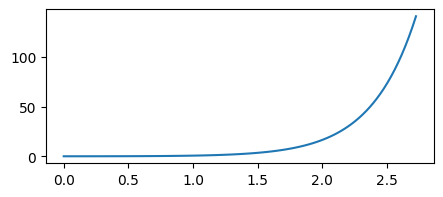

In [49]:
time, response = ctl.step_response(G)
plt.figure(figsize=(5, 2))
plt.plot(time, response)

- Encontrando as características da resposta transitória e permanente

In [50]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.0
valor de pico:  140.71111244248542
tempo de pico:  2.7252219003059777
tempo de assentamento:  None
valor final:  140.71111244248542
erro:  139.71111244248542


- Encontrando os polos do sistema

In [51]:
polos = ctl.pole(G)
zeros = ctl.zeros(G)

display(sp.Matrix(polos))
display(sp.Matrix(zeros))

Matrix([
[2.53535763972587],
[2.53474965770918]])

Matrix([
[1.28733886370655 + 2.18386250381214*I],
[1.28733886370655 - 2.18386250381214*I]])

# REQUISITOS DO SISTEMA

### REQUISITOS NO TEMPO
- O primeiro parâmetero é que o erro seja nulo, ou seja $c(\infty) = \lim_{t \to \infty} c(t) = \lim_{s \to 0} s\,C(s) = \lim_{s \to 0} s\,G(s)R(s)= 0$

- O segundo parâmetro se refere à resposta transitória do sistema, ou seja, queremos alguma informação da resposta transitória que nos dê $\zeta$. Um bom parâmetro é o tempo de estabilização $T_s$, gostaria que $T_s$ fosse pequeno.

$T_s = \frac{4}{\zeta\omega_n}$


In [52]:
Ts = 5.0
UP = 0.5

In [53]:
zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
zeta

0.2154537619662468

In [54]:
Wn = 4/(zeta*Ts)
Wn

3.713093671232015

### ROOT LOCUS
Uma maneira de encontrar o polo desejado $s_D$ para o controlador é encontrando a interseção da linha vertical projetada por $\zeta$ com o caminho percorrido pelo LGR. O root locus nos dá uma informação importante sobre como é possível controlar o sistema, mostrando o caminho pelo qual os polos e zeros podem percorrer para chegar em uma estabilidade, ou seja, no semiplano esquerdo

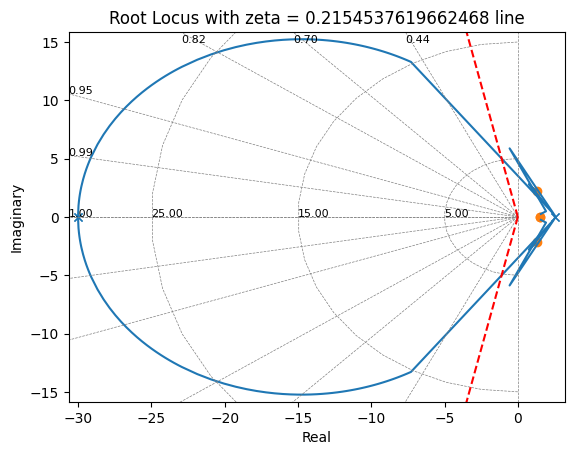

In [56]:
def zGrid(G, zeta):
    ctl.root_locus(G)

    angle  = np.arccos(zeta)
    radius = np.linspace(0, 100, 400)

    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    
    plt.plot(-x, y, 'r--')
    plt.plot(-x, -y, 'r--')

    plt.title(f'Root Locus with zeta = {zeta} line')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.show()

C_aux = (s - 1.5)*(s - 1.5)/(s + 30)/(s + 30)
zGrid(G*C_aux, zeta)
#1/0

In [12]:
print(sympyFunction(G * C_aux))
display(G * C_aux)

(0.00321649789783711*s**4 - 0.0179309391913436*s**3 + 0.05275227016486*s**2 - 0.0806456925738117*s + 0.0465093301527668)/(0.15560577*s**4 + 8.54740825*s**3 + 93.708916*s**2 - 650.044155*s + 900.0)


TransferFunction(array([ 0.0032165 , -0.01793094,  0.05275227, -0.08064569,  0.04650933]), array([ 1.55605770e-01,  8.54740825e+00,  9.37089160e+01, -6.50044155e+02,
        9.00000000e+02]))

### POLO DESEJADO

$s = -\zeta\omega_n \pm \omega_n\sqrt{1-\zeta²}j$

In [13]:
s_desired = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
#s_desired = -0.2103+0.28046*sp.I
s_desired

-0.8 + 3.62588811346175*I

# TABELA DE ROUTH

In [14]:
K, s = sp.symbols('K s')
G_s  = K * sympyFunction(G * C_aux)

T = sp.cancel(G_s/(1 + G_s))
T = roundSympyFunction(T)
T

(0.000501*K*s**8 + 0.024703*K*s**7 + 0.15636*K*s**6 - 3.332808*K*s**5 + 18.812034*K*s**4 - 57.588836*K*s**3 + 104.258643*K*s**2 - 102.814242*K*s + 41.858397*K)/(0.000501*K*s**8 + 0.024703*K*s**7 + 0.15636*K*s**6 - 3.332808*K*s**5 + 18.812034*K*s**4 - 57.588836*K*s**3 + 104.258643*K*s**2 - 102.814242*K*s + 41.858397*K + 0.024213*s**8 + 2.660052*s**7 + 102.221484*s**6 + 1399.635481*s**5 - 2050.934223*s**4 - 106444.531384*s**3 + 591233.45225*s**2 - 1170079.479*s + 810000.0)

In [14]:
num, den = sp.fraction(T)

routhTable = routh(sp.poly(den, s))
routhTable = roundSympyFunction(routhTable)

routhTable

In [ ]:
firstRow = routhTable[:, 0]
firstRow

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   0.000501*K + 0.024213],
[                                                                                                                                                                                                                                                                  

In [ ]:
equations = [value > 0 for value in firstRow]
equations

[0.000501*K + 0.024213 > 0,
 0.003681*K + 0.723 > 0,
 (-0.000625*K**2 - 0.047463*K + 2.088768)/(0.003681*K + 0.723) > 0,
 (0.000318*K**3 - 0.017474*K**2 - 3.102119*K + 303.523722)/(0.000625*K**2 + 0.047463*K - 2.088768) > 0,
 (4.6e-5*K**5 - 0.001859*K**4 - 0.809115*K**3 + 32.404801*K**2 + 4453.021195*K - 145485.113689)/(-1.0e-5*K**4 - 0.00219*K**3 + 0.133888*K**2 + 12.766675*K - 458.375235) > 0,
 (-1.0e-5*K**4 - 0.00219*K**3 + 0.133888*K**2 + 12.766675*K - 458.375235)*(1.4e-5*K**7 + 0.001767*K**6 - 0.327459*K**5 - 18.307225*K**4 + 2964.093951*K**3 + 56497.330196*K**2 - 8794108.367795*K + 154410125.584489)/((-2.0e-6*K**5 + 0.018904*K**3 + 0.039977*K**2 - 48.422476*K + 957.439464)*(-4.6e-5*K**5 + 0.001859*K**4 + 0.809115*K**3 - 32.404801*K**2 - 4453.021195*K + 145485.113689)) > 0,
 (-7.0e-6*K**16 + 2.0e-5*K**15 + 0.065533*K**14 - 1.079381*K**13 - 455.593824*K**12 + 13839.200536*K**11 + 2177489.282413*K**10 - 100586573.156721*K**9 - 6297900042.59553*K**8 + 441999126914.496*K**7 + 65331778

In [ ]:
solutions  = sp.solve(equations, K)
solutions = roundSympyFunction(solutions, 3)
print(solutions)

(-48.329 < K) & (K < oo) & (((-110.814 < K) & (K < -107.133)) | ((31.194 < K) & (K < oo))) & (((-107.133 < K) & (K < 31.194)) | ((-oo < K) & (K < -196.414))) & (((-57.623 < K) & (K < 25.124)) | ((-oo < K) & (K < -120.851))) & (((-76.993 < K) & (K < 31.196)) | ((31.626 < K) & (K < 75.538)) | ((-oo < K) & (K < -248.873))) & (((-187.936 < K) & (K < -76.99)) | ((31.189 < K) & (K < 31.626)) | ((75.535 < K) & (K < 84.22)) | ((-oo < K) & (K < -248.681)))


# CONTROLADOR
- Encontrando as constantes do controlador: $C(s) = K\frac{(s-a)(s-b)}{s(s+p)}$

- $p$ é um polo colocado arbitrariamente pois o número de polos tem que ser maior ou igual o número de zeros, para que seja possível implementá-lo digitalmente, com uma função de transferência própria. Esse polo $p$ precisa estar longe do eixo imaginário para que tenha pouca influência no sistema

In [15]:
s = sp.symbols('s')
K, a, b = sp.symbols('K a b', real=True)

### MALHA ABERTA
- A função de transferência final em malha aberta será $G(s)C(s)$

In [16]:
C     = K * ((s + a) * (s + b)) / (s * (s + 20))
C_bkp = str(C)

C

K*(a + s)*(b + s)/(s*(s + 20))

In [17]:
GC = sympyFunction(G * C_aux) * C
GC

K*(a + s)*(b + s)*(0.00321649789783711*s**4 - 0.0179309391913436*s**3 + 0.05275227016486*s**2 - 0.0806456925738117*s + 0.0465093301527668)/(s*(s + 20)*(0.15560577*s**4 + 8.54740825*s**3 + 93.708916*s**2 - 650.044155*s + 900.0))

In [18]:
ZERO = 1e-10

### EQUAÇÃO 1 - ERRO EM REGIME PERMANENTE
- Erro em regime permanente para entrada em degrau é igual a zero (malha fechada)

- $erro = \frac{1}{1+K_p}$ onde $K_p = \lim_{s\to 0} G(s)$

In [19]:
Kp  = GC.subs(s, ZERO).expand().simplify()
eq1 = 1/(1 + Kp)
eq1 = roundSympyFunction(eq1)

eq1 = sp.Eq(eq1, ZERO)
eq1

Eq(1/(K*(25838.516749*a*b + 3.0e-6*a + 3.0e-6*b) + 1), 1.0e-10)

### EQUAÇÃO 2 - SOMA DOS ÂNGULOS
- A soma dos angulos da função de transferência em malha aberta + 180º é igual a zero para o $s$ desejado

In [20]:
G_aux = GC.subs(s, s_desired)
angle = sp.arg(G_aux)
angle = roundSympyFunction(angle)

eq2 = sp.Eq(angle + sp.pi, ZERO)
eq2

Eq(arg(-K*(0.8 + 3.625888*I)*(19.2 - 3.625888*I)*(a - 0.8 + 3.625888*I)*(b - 0.8 + 3.625888*I)*(0.111026 + 0.052752*(-0.8 + 3.625888*I)**2 - 0.292412*I + 0.003216*(-0.8 + 3.625888*I)**4 - 0.017931*(-0.8 + 3.625888*I)**3)/(1420.035324 - 2356.987375*I + 93.708916*(-0.8 + 3.625888*I)**2 + 8.547408*(-0.8 + 3.625888*I)**3 + 0.155606*(-0.8 + 3.625888*I)**4)) + pi, 1.0e-10)

### EQUAÇÃO 3 - MÓDULO
- O módulo da função de transferência em malha aberta é igual a 1 para o $s$ desejado

In [21]:
G_aux  = GC.subs(s, s_desired)
modulo = sp.Abs(G_aux).expand().simplify()
modulo = roundSympyFunction(modulo)

eq3 = sp.Eq(modulo - 1, ZERO)
eq3

Eq(5.3981130420061e-5*sqrt(0.072532*a**2 - 0.116051*a + 1)*sqrt(0.072532*b**2 - 0.116051*b + 1)*Abs(K) - 1, 1.0e-10)

### RESOLUÇÃO DO SISTEMA

In [22]:
def convertString(eq):
    substitutions = {
        'sqrt': 'np.sqrt',
        'Abs' : 'np.abs',
        'pi'  : 'np.pi',
        'arg' : 'np.angle',
        '*I'  : 'j',
        'I)'  : '1j)'
    }

    result = str(eq.lhs)
    for key, value in substitutions.items():
        result = result.replace(key, value)

    return result


str_eq1 = convertString(eq1)
str_eq2 = convertString(eq2)
str_eq3 = convertString(eq3)

print(str_eq1)
print(str_eq2)
print(str_eq3)

1/(K*(25838.516749*a*b + 3.0e-6*a + 3.0e-6*b) + 1)
np.angle(-K*(0.8 + 3.625888j)*(19.2 - 3.625888j)*(a - 0.8 + 3.625888j)*(b - 0.8 + 3.625888j)*(0.111026 + 0.052752*(-0.8 + 3.625888j)**2 - 0.292412j + 0.003216*(-0.8 + 3.625888j)**4 - 0.017931*(-0.8 + 3.625888j)**3)/(1420.035324 - 2356.987375j + 93.708916*(-0.8 + 3.625888j)**2 + 8.547408*(-0.8 + 3.625888j)**3 + 0.155606*(-0.8 + 3.625888j)**4)) + np.pi
5.3981130420061e-5*np.sqrt(0.072532*a**2 - 0.116051*a + 1)*np.sqrt(0.072532*b**2 - 0.116051*b + 1)*np.abs(K) - 1


In [23]:
def sistema(variaveis):
    (K, a, b) = variaveis
    return [
        eval(str_eq1), 
        eval(str_eq2),
        eval(str_eq3)
    ]

guess     = [1, 1, 1]
solutions = fsolve(sistema, guess, maxfev=10000000, xtol=ZERO)
print('Solucoes:', solutions, '\n')

Solucoes: [6.80909201e+03 5.73605668e+00 5.73557626e+00] 



In [24]:
for eq in [eq1, eq2, eq3]:
    sol = eq.lhs.subs({
        K: solutions[0],
        a: solutions[1],
        b: solutions[2]
    })
    print(sp.N(sol))

1.72763790887408e-10
3.15557935871520e-7
6.92157989368170e-7


In [25]:
K = solutions[0]
a = solutions[1]
b = solutions[2]

### CONTROLADOR
- Função de transferência do controlador $C(s)$

In [26]:
s = ctl.TransferFunction.s
C = C_aux * eval(C_bkp)

print(sympyFunction(C))
C

(6809.09201100924*s**4 + 57684.1281664344*s**3 + 5002.58336870349*s**2 - 496298.357378168*s + 504036.762620218)/(s**4 + 80*s**3 + 2100*s**2 + 18000*s)


TransferFunction(array([   6809.09201101,   57684.12816643,    5002.5833687 ,
       -496298.35737817,  504036.76262022]), array([    1,    80,  2100, 18000,     0]))

- Função de transferência do sistema em malha aberta $C(s)G(s)$

In [27]:
GC = G*C
GC

TransferFunction(array([    21.90143014,    129.15175261,   -320.86769422,   -445.39339518,
         5834.70845203, -14433.04371524,  10418.84986748]), array([ 1.55605770e-01,  1.16595237e+01,  2.64657081e+02,  1.22413416e+03,
       -1.21008831e+04,  1.80000000e+04,  0.00000000e+00]))

- Função de transferência em malha fechada com realimentação unitária $G_{feedback}(s) = \frac{G(s)C(s)}{1+G(s)C(s)}$

In [28]:
G_feedback = ctl.feedback(GC, 1)
G_feedback

TransferFunction(array([    21.90143014,    129.15175261,   -320.86769422,   -445.39339518,
         5834.70845203, -14433.04371524,  10418.84986748]), array([   22.05703591,   140.81127626,   -56.21061322,   778.74076982,
       -6266.17464797,  3566.95628476, 10418.84986748]))

In [29]:
ctl.poles(G_feedback)

array([-7.88207547+0.j        , -0.80022032+3.62580312j,
       -0.80022032-3.62580312j,  2.03961321+0.52195459j,
        2.03961321-0.52195459j, -0.98067217+0.j        ])

# APLICANDO UM STEP

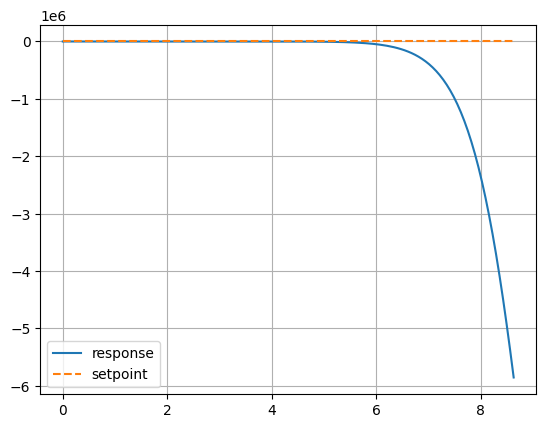

In [30]:
    time, response = ctl.step_response(G_feedback)
    plt.plot(time, response, label='response')
    plt.plot(time, [1 for i in time], '--', label='setpoint')
    plt.legend()
    plt.grid()

In [31]:
getAllInfo(time, response, setpoint=1)

overshoot:  inf
valor de pico:  44.34602020681965
tempo de pico:  3.2371187701692055
tempo de assentamento:  None
valor final:  -5854016.516634451
erro:  5854015.516634451


# APLICANDO VÁRIOS STEPS

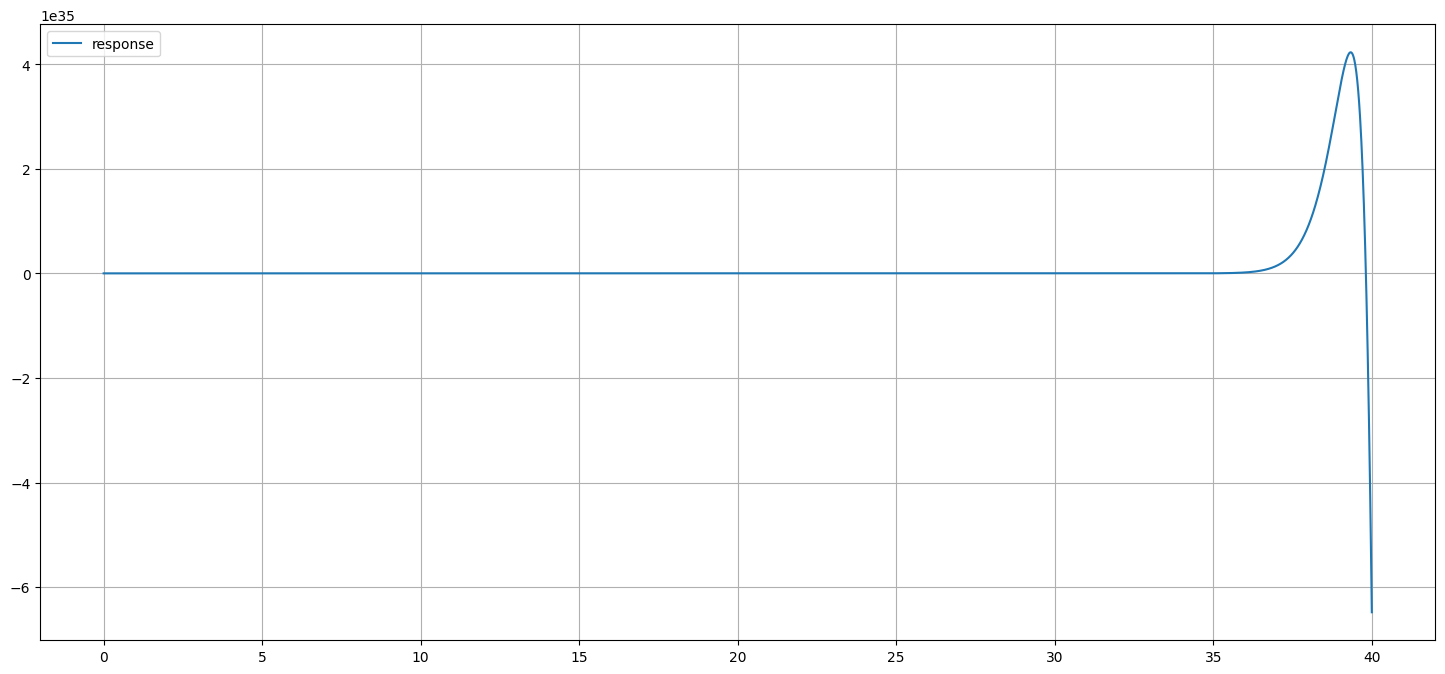

In [32]:
uData = [100 for i in range(1000)] + [0 for i in range(1000)] + [-100 for i in range(1000)] + [50 for i in range(1000)]
tData = np.linspace(0, 40, len(uData))

plt.figure(figsize=(18, 8))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.legend()
plt.grid()